In [1]:
import numpy as np
import os
import json
import pandas as pd
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
import h5py
from io import StringIO
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import itertools
import xlsxwriter as Excel

In [2]:

def gene_expression_cluster_analysis(h5_filepath,
                                     on_samples = True,
                                     samples_filter_to = None,
                                     genes_filter_to = None,
                                     sample_labels = None,
                                     value_transformation = "raw",
                                     hier_method = "average",
                                     hier_distance_metric = "euclidean",
                                     hier_k = 4,
                                     hier_fcluster_t = 4,
                                     output_xlsx_folder = ".",
                                     output_dendro_folder="."):
    
    """
Performs gene expression cluster analysis using one or combination of hierarchical, k-means, and SPC.


Arguments:

    h5_filepath (str): filepath to h5 file of interest (human, mouse)
    
    on_samples (boolean): if True, algorithm performs one-way cluster on samples 
                           based on gene expression
    
    samples_filter_to (list [str]): list of samples to filter to in matrix. 
                       If None, then all samples will be analyzed
                       
    genes_filter_to (list [str]): list of genes to filter to in matrix.
                       If None, then all genes will be analyzed
    
    sample_labels (list [str]): list of same length as samples_filter_to that 
                   labels the source tissue/cell line from which
                   the sample was obtained from. If None, then
                   Sample_source_name_ch1 from h5 metadata will
                   be used
                   
    value_transformation (str): how to transform the values in the h5 matrix
                          can be one of ["raw","normalize","binary"]
                          "raw" by default
                          TODO: implement library size,
                                          DESeq, 
                                          Relative Log Expression (RLE), 
                                          upper quartile (UQ), 
                                          Trimmed Mean of M values (TMM),
                                          Total Ubiquitous (TU), 
                                          Network Centrality Scaling (NCS), 
                                          Evolution Strategy (ES),
                                          pooled size factors (Pooled) (Lun et. al),
                                          SCnorm
    hier_method (str): specify the method of hierarhcical linkage to be one of 
                 ('average', 'complete', 'single', 'weighted', 'centroid', 'median' , 'ward')
    
    hier_distance_metric (str): specify the distance metric used in hierarchical clustering to be one of:
                                (‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, 
                                ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, 
                                ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, 
                                ‘sokalsneath’, ‘sqeuclidean’, ‘yule’)
                 
    
    hier_k (int): Number of clusters to output from hierarchical clustering. Default to 4
    
    hier_fcluster_metric (str): one of ('inconsistent','distance','maxclust','monocrit','maxclust_monocrit')
    
    hier_fcluster_t (float): https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.fcluster.html
                                    
    output_xlsx_folder: where to save the generated purity tables for each cluster_method+cluster
    
    output_dendro_folder: where to save generated dendrograms from hierarchical clustering
    
    Returns:

    hier_cluster_dendrogram (matplotlib.pyplot): dendrogram of chosen hierarchical clustering procedure
    """
    
    #get submatrix based on filter_to arguments
    h5_submatrix, sample_labels = filter_matrix(h5_filepath,samples_filter_to,genes_filter_to,sample_labels)
    #make sure sample labels is same length as number of samples in submatrix
    #otherwise a data entry error occurred and we need to terminate
    if h5_submatrix.shape[1] != len(sample_labels):
        print("Error: provided sample_labels not the correct length. Terminating program")
        return
    
    #if sample_on = True, need to transpose the matrix for further calculations
    if on_samples:
        h5_submatrix = np.transpose(h5_submatrix)
    
    #Go through possible value normalizing transformations
    
    if value_transformation == "normalize":
        transformed_submatrix = pd.DataFrame(normalize(np.array(h5_submatrix)),index=h5_submatrix.index,columns=h5_submatrix.columns)
    #other normalizations to implement
    #elif value_transformation == "":
    else:
        transformed_submatrix = h5_submatrix
            
    hier_title=hier_method+" Link Hierarchical Dendrogram, "+hier_distance_metric+", "+value_transformation    
    hier_clustering = hierarchical_clustering(transformed_submatrix, 
                                              method=hier_method, 
                                              metric=hier_distance_metric, 
                                              title=hier_title)
        
    hier_cluster_assignments = fcluster(hier_clustering, hier_fcluster_t, criterion='maxclust')
    
    get_purity(h5_filepath, hier_cluster_assignments, hier_k, transformed_submatrix, sample_labels, hier_title, output_xlsx_folder)
      
        
    plt.figure(figsize=(25, 20))  
    plt.title(hier_title)  
    dend = shc.dendrogram(hier_clustering)
    plt.savefig('foo.png')
        
    return(hier_clustering, hier_cluster_assignments)
    

#INPUTS: 
#  h5filepath: path where the full matrix is stored with meta and expression data
#  subsamples: a pandas DataFrame that must contain a column (foreign key) called SampleGeoAccession
#OUTPUT
#  merged dataframe of length(subsamples) merged with relevant meta/Sample values for cluster analysis
def h5_sample_meta_lookup(h5filepath,subsamples,sample_labels):
    f = h5py.File(h5filepath, 'r')
    full_data = pd.DataFrame({"Description":f[("meta/samples/data_processing")], 
                          "Characteristics":f[("meta/samples/characteristics_ch1")],
                          "SampleGeoAccession":f[("meta/samples/geo_accession")],
                          "Series ID":f[("meta/samples/series_id")],
                          "Molecule":f["meta/samples/molecule_ch1"],
                          "Source Name":f["meta/samples/title"]})
    f.close()
    full_data["SampleGeoAccession"] = full_data["SampleGeoAccession"]
    cluster_meta = subsamples.merge(full_data,on="SampleGeoAccession",how="left")
    cluster_meta["Sample_Label"] = pd.Series(sample_labels).str.replace(".csv","").str.replace("_expression"," ")
    cluster_meta["Series ID"] = cluster_meta["Series ID"].str.replace("Xx","").str.replace("xX","")
    cluster_meta["Molecule"] = cluster_meta["Molecule"]
    cluster_meta["Source Name"] = cluster_meta["Source Name"].str.decode("utf-8")
    cluster_meta["Description"] = cluster_meta["Description"].str.replace("Xx","").str.replace("xX","")
    cluster_meta["Characteristics"] = cluster_meta["Characteristics"].str.replace("Xx","").str.replace("xX","")
    return(cluster_meta)

def purity_to_excel(cluster_metadata_metrics, H0, out_filepath):
    workbook = Excel.Workbook(out_filepath)
    worksheet = workbook.add_worksheet()
    cluster_format = workbook.add_format({'bold': True, 'align':'center'})
    center = workbook.add_format({'align': 'center'})

    # Add a format. Light red fill with dark red text.
    format1 = workbook.add_format({'bg_color': '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Add a format. Green fill with dark green text.
    format2 = workbook.add_format({'bg_color': '#C6EFCE',
                                   'font_color': '#006100'})

    worksheet.write('A1', "Cluster ID",cluster_format)
    worksheet.write('B1', "Cluster Size",center)
    worksheet.write('C1', "Dominant Molecule",center)
    worksheet.write('D1', "Molecule Purity",center)
    worksheet.write('E1', "Dominant Series",center)
    worksheet.write('F1', "Series Purity",center)
    worksheet.write('G1', "Dominant Label",center)
    worksheet.write('H1', "Label Purity",center)
    worksheet.write('I1', "Null Hypothesis Value",center)

    worksheet.set_column(1, 7, 15)

    num_keys = len(list(cluster_metadata_metrics.keys()))

    j = 1
    for i in np.sort(list(cluster_metadata_metrics.keys())):
        worksheet.write(j,0,i,center)
        worksheet.write(j,1,cluster_metadata_metrics[i]["Size"],center)
        worksheet.write(j,2,list(cluster_metadata_metrics[i]["Molecule Purity"].keys())[0],center)
        worksheet.write(j,3,list(cluster_metadata_metrics[i]["Molecule Purity"].values())[0],center)
        worksheet.write(j,4,list(cluster_metadata_metrics[i]["Series Purity"].keys())[0],center)
        worksheet.write(j,5,list(cluster_metadata_metrics[i]["Series Purity"].values())[0],center)
        worksheet.write(j,6,list(cluster_metadata_metrics[i]["Label Purity"].keys())[0],center)
        worksheet.write(j,7,list(cluster_metadata_metrics[i]["Label Purity"].values())[0],center)
        worksheet.write(j,8,H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],center)
        
        

        # Write a conditional format over a range.
        worksheet.conditional_format('H'+str(j+1), {'type': 'cell',
                                             'criteria': '>=',
                                             'value': H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],
                                             'format': format2})

        # Write another conditional format over the same range.
        worksheet.conditional_format('H'+str(j+1), {'type': 'cell',
                                             'criteria': '<',
                                             'value': H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],
                                             'format': format1})

        j += 1

    workbook.close()


def get_purity(h5_filepath, cluster_assignments, k, df_expression_trans,sample_labels,cluster_title,output_xlsx_folder):
    cluster_dict = {"SampleGeoAccession":[],"ClusterAssignment":[]}
    cluster_dict["SampleGeoAccession"] = df_expression_trans.index
    cluster_dict["ClusterAssignment"] = cluster_assignments
    cluster_info = pd.DataFrame(cluster_dict)
    cluster_metadata = h5_sample_meta_lookup(h5_filepath,cluster_info,sample_labels).sort_values("ClusterAssignment")
    
    #hypothesized values of expected sample frequencies assuminfg no separation (based on observed proportion of sample labels)
    H0 = {}
    for samp in cluster_metadata.Sample_Label:
        H0[samp] = len(cluster_metadata[cluster_metadata.Sample_Label == samp])/len(cluster_metadata)
    
    cluster_metadata_metrics = {}
    for c in range(1,k+1):
        cluster_metadata_metrics[c] = {"Size":len(cluster_metadata.loc[cluster_metadata.ClusterAssignment == c]), 
                                       "Molecule Purity":{},"Series Purity":{},"Label Purity":{}}
        series_counts = cluster_metadata.groupby('ClusterAssignment')["Series ID"].value_counts()
        molecule_counts = cluster_metadata.groupby('ClusterAssignment')["Molecule"].value_counts()
        label_counts = cluster_metadata.groupby('ClusterAssignment')["Sample_Label"].value_counts()

        series_purity_key = pd.Series(series_counts[c][series_counts[c] == series_counts[c].max()]).index[0]
        series_purity_val = series_counts[c].max()/float(series_counts[c].sum())
        cluster_metadata_metrics[c]["Series Purity"][series_purity_key] = round(series_purity_val,3)
    
        molecule_purity_key = molecule_counts[c][molecule_counts[c] == molecule_counts[c].max()].index[0]
        molecule_purity_val = molecule_counts[c].max()/float(molecule_counts[c].sum())
        cluster_metadata_metrics[c]["Molecule Purity"][molecule_purity_key] = round(molecule_purity_val,3)

        label_purity_key = label_counts[c][label_counts[c] == label_counts[c].max()].index[0]
        label_purity_val = label_counts[c].max()/float(label_counts[c].sum())
        cluster_metadata_metrics[c]["Label Purity"][label_purity_key] = round(label_purity_val,3)
    purity_to_excel(cluster_metadata_metrics,H0,os.path.join(output_xlsx_folder,cluster_title+" purity" + ".xlsx") )
    
    
"""
Performs Hierarchical Clustering and returns

"""
def hierarchical_clustering(df,title,method="average",metric="euclidean"):
    clustering = shc.linkage(df, method=method, metric=metric)
    #plt.figure(figsize=(25, 20))  
    #plt.title(title)  

    #dend = shc.dendrogram(clustering) 
    print("Cophenet = " + str(cophenet(clustering, pdist(df))[0]))
    return(clustering)

"""
normalizes (L2) a gene expression matrix such that sum of values for each sample equals 0
and each row (sample) has same standard deviation
"""
def normalize(X):
    return (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)

#converts to df to binary dataframe, 0 representing that the previous value was 0, and 1 indicating a nonzero value
def df_to_binary(df_expression):    
    temp = df_expression.copy()
    num_rows = len(temp)
    for c in range(len(df_expression.columns)):
        nonzero_inds = df_expression.iloc[:,c].to_numpy().nonzero()[0]
        temp_col = np.zeros(num_rows)
        temp_col[nonzero_inds] = 1
        temp.iloc[:,c] = temp_col
    return(temp)


def filter_matrix(h5_filepath,
                  samples_filter_to, 
                  genes_filter_to,
                 sample_labels):
    
    #samples_filter_to = list(map(lambda x : bytes(x,encoding="utf-8"),samples_filter_to))
    
    #obtain submatrix based on provided filter_to lists
    with h5py.File(h5_filepath, "r") as h5file:
        h5_matrix = h5file['data']['expression']

        all_samples = np.array(h5file["meta/samples/geo_accession"])
        all_genes = np.array(h5file["meta/genes/genes"])
        
        
        num_samples = len(all_samples)
        num_genes = len(all_genes)

        if samples_filter_to is None:
            print("No sample filter is specified, do you wish to proceed to cluster on all %d samples?" % num_samples)

            if genes_filter_to is None:
                print("No gene filter is specified, do you wish to proceed to cluster on all %d genes?" % num_genes)    
                h5_submatrix = h5_matrix
                cols = all_samples
                inds = all_genes
            else:
                h5_submatrix = h5_matrix[np.isin(all_genes,genes_filter_to),:]
                cols = all_samples
                inds = genes_filter_to


            if sample_labels is None:
                sample_labels = h5file["meta/samples/source_name_ch1"]


        else:
            print("No gene filter is specified, do you wish to proceed to cluster on all %d genes?" % num_genes)    
            if genes_filter_to is None:
                h5_submatrix = h5_matrix[:,np.isin(all_samples,samples_filter_to)] 
                cols = samples_filter_to
                inds = all_genes
               
            else:
                h5_submatrix =  np.array(h5_matrix[np.isin(all_genes,genes_filter_to),np.isin(all_samples,samples_filter_to)])
                cols = samples_filter_to
                inds = genes_filter_to

            if sample_labels is None:
                sample_labels = h5file["meta/samples/source_name_ch1"][np.isin(all_samples,samples_filter_to)]
                
    return(pd.DataFrame(h5_submatrix,index=inds,columns=cols),sample_labels)

In [7]:
h5_filepath = "../data/raw/human_matrix_v9.h5"
subsample_filepath = "subsample_dict.json"

#extract samples to compare for clustering as in this example using the dictionary json file:
with open(subsample_filepath,'r') as f:
    subsample_dict = json.loads(f.read())

ovary_samples = subsample_dict["human"]["systems"]["urogenital"]["Ovary"]
ovary_cell_lines = subsample_dict["human"]["cell-lines"]["ovary"]["SKOV3"]

samples_filter_to = ovary_samples + ovary_cell_lines

sample_labels = list(np.repeat("Ovary",len(ovary_samples))) + list(np.repeat("SKOV3",len(ovary_cell_lines)))

genes_filter_to = None

value_transformation = "normalize"

hier_method = "average"

hier_distance_metric = "euclidean"

hier_k = 12

hier_fcluster_t = 12

output_xlsx_folder = "../data/processed/tables"

output_dendro_folder = "../data/processed/figures"

No gene filter is specified, do you wish to proceed to cluster on all 35238 genes?
Cophenet = 0.8946588118407035


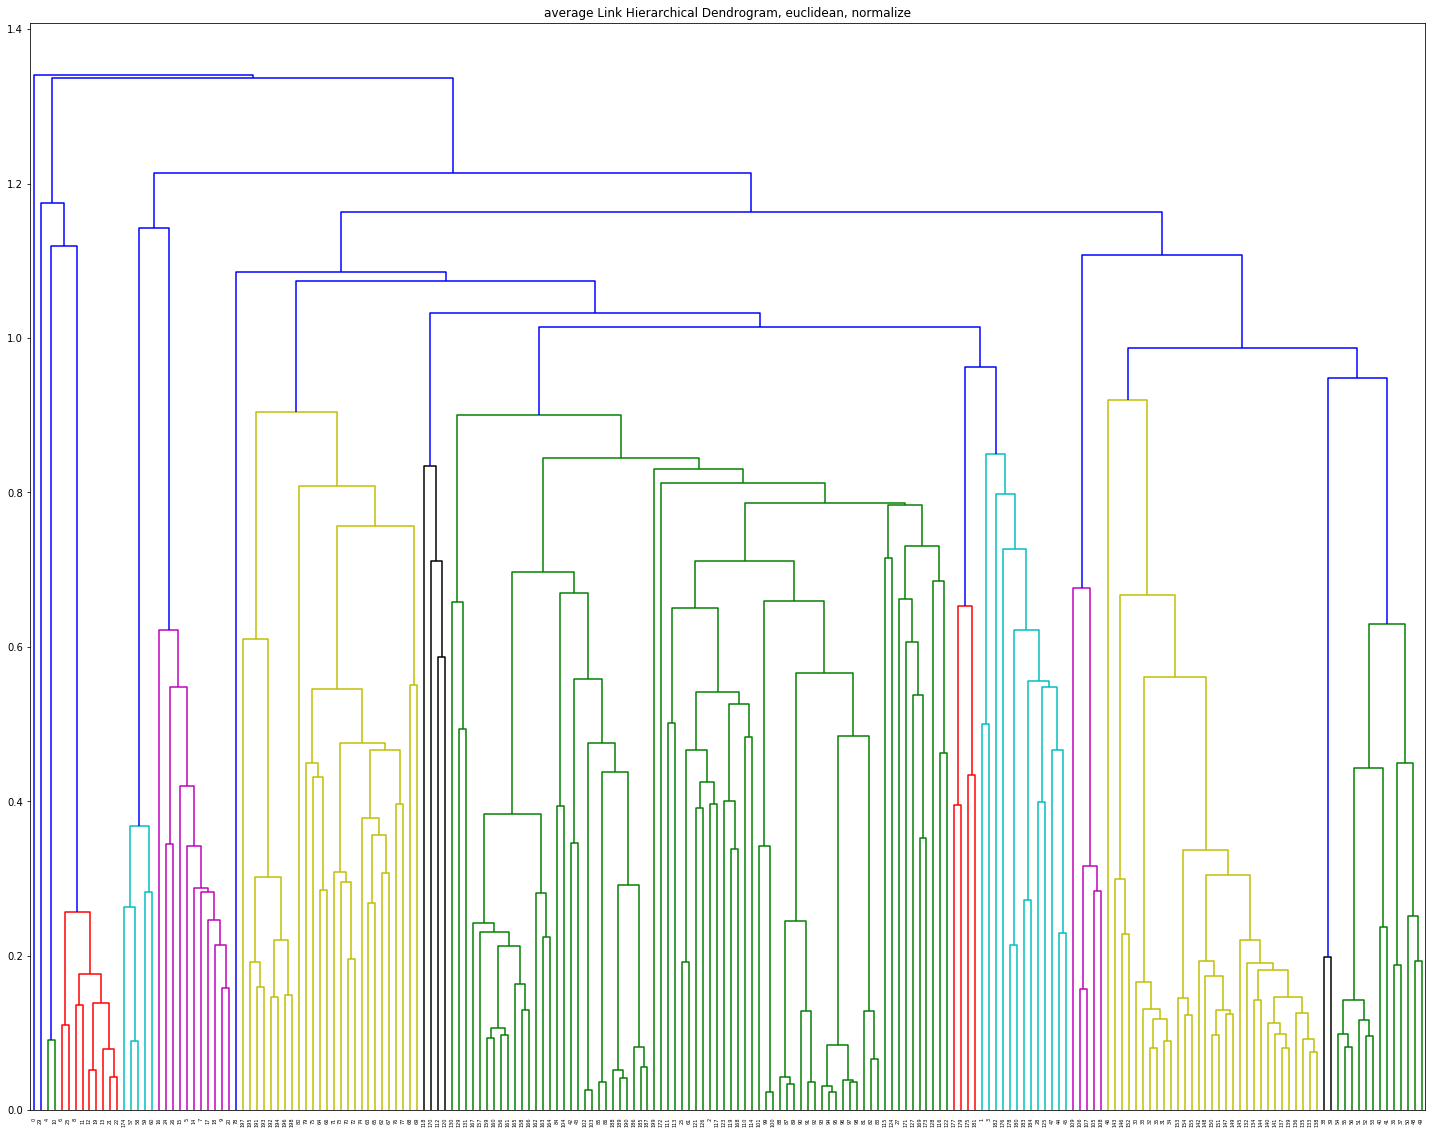

In [8]:
a = gene_expression_cluster_analysis(h5_filepath,
                                 True,
                                 samples_filter_to,
                                 genes_filter_to,
                                 sample_labels,                                 
                                 value_transformation,
                                 hier_method,
                                 hier_distance_metric,
                                 hier_k,
                                 hier_fcluster_t,
                                 output_xlsx_folder)

In [ ]:
with h5py.File(h5_filepath, "r") as h5file:
    print(h5file["meta/samples"].keys())

# Gene Shaving

In [ ]:
file_list = ["ALPHA_expression.csv","beta_expression.csv","PANC1_expression.csv"]
df,sample_source = preprocess_samples(file_list)

In [ ]:
#Let X be N (genes) x P (samples) expression matrix (pandas dataframe)
def gene_shave(df):
    #clusters where clusterID (key) also represents the size k, values are a list of inds of genes belonging to cluster
    S = {}
    xbarSk = {}
    #remove rows of all zeros
    df_nonzero = df[(df.T != 0).any()]
    genes = np.array(df_nonzero.index)
    samples = list(df_nonzero.columns)
    X = np.array(df_nonzero)
    X = (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)
    X_copy = X.copy()
    while(X_copy.shape[0] > 1):
        corr = np.corrcoef(np.transpose(X_copy))
        w,v = np.linalg.eig(corr)
        #leading principal component is vmax
        vmax = v[0]
        dot_prods = np.dot(X_copy,vmax)
        dot_prods_argsort = np.argsort(dot_prods)
        #save the inds of top 90% of rows with respect to dot product with vmax
        top90perc = np.where(dot_prods_argsort > len(dot_prods_argsort)*0.1)[0]
        S[len(top90perc)] = genes[top90perc]
        xbarSkhat = np.mean(X_copy[top90perc,:],axis=0)
        xbarSk[len(top90perc)] = xbarSkhat
        #remove the bottom 10% of X_copy's rows with respect to dot product with vmax
        X_copy = X_copy[top90perc,:]
        genes = genes[top90perc]
    return(S,xbarSk)

In [ ]:
S, xbarSk = gene_shave(df)

In [ ]:
def Dk(df,k,xbar):
    Dks = []
    sumVw = 0.0
    sumVb = 0.0
    #sum over p columns
    jcnt = 0
       
    for j in df.columns: 
        #sum over each gene in Sk
        #print("OK" + str(xbar.shape))
        sumVw = np.sum((df.loc[:,j] - xbar[jcnt])**2)
        #or i in S[k]:
        #    sumVw += (df.loc[i,j] - xbar[jcnt])**2
        sumVb = np.sum((xbar[jcnt] - 0)**2)
        jcnt += 1
    Vw = sumVw/(k*len(df.columns))
    Vb = sumVb/len(df.columns)
    Vt = Vw+Vb
    Dks.append((Vb/Vw)/(1+(Vb/Vw)))
    return(Dks[0])

def findK(S, xbarSk, df, B=5):
    
    Gapk = {}
    Dks = {}
    D_k_b = {}
    for k in S:
        print(k)
        D_k_b[k] = []
        D_k = Dk(df.loc[S[k],:],k,xbarSk[k])
        for i in range(B):
            df_copy = df.sample(k,replace=False)
            xbar = np.mean(np.array(df_copy),axis=0)
            D_k_b[k].append(Dk(df,k,xbar))
        Dks[k] = (D_k)
    return(Dks,D_k_b)
        
                
                

In [ ]:
#find the optimum value of k based on R^2 values. Choose the value of k with the highest value
df_nonzero = df[(df.T != 0).any()]
genes = np.array(df_nonzero.index)
X = np.array(df_nonzero)
X = (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)
df_norm = pd.DataFrame(X,index=df_nonzero.index,columns=df_nonzero.columns)
Dks,Dkbs = findK(S, xbarSk , df_norm)

Select genes for visualization purposes (k=6 seems to be the winner)

In [ ]:
gapK = {}
for i in Dks:
    gapK[i] = Dks[i] - np.mean(Dkbs[i])

In [ ]:
gapK

In [ ]:
S[80]

In [ ]:
list(df_nonzero.columns)

# Transfer fcluster output to csv for R heatmap

In [ ]:
def sortDF(df, cluster_assignments, outfile):
    sample_list_sorted = []
    for i in np.unique(cluster_assignments):
        for j in list(df.index[cluster_assignments == i]):
            sample_list_sorted.append(j)
    df.loc[sample_list_sorted,:].to_csv(outfile)  

In [ ]:
sortDF(np.transpose(df_norm),fcluster(clustering, len(sample_list), criterion='maxclust'),"haha.csv")

In [ ]:
fcluster(clustering, len(df_expression_trans), criterion='maxclust')

In [ ]:
np.unique(cluster_assignments)

In [ ]:
df_expression_trans

In [ ]:
np.unique(test_ass)

In [ ]:
sample_list_sorted = []
for i in np.unique(test_ass):
    for j in test_ass[test_ass == i]:
        sample_list_sorted.append(sample_list[i])
df_expression_trans.loc[sample_list_sorted,:]    

In [ ]:
sample_list_sorted

# XGBoost classification

In [ ]:
from xgboost import XGBClassifier
import sqlite3 #sqlite will suffice due to small magnitude of projected data
from sqlite3 import Error
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
file_list = ["PANC1_expression.csv","ALPHA_expression.csv","beta_expression.csv"]
df,sample_source = preprocess_samples(file_list)

In [ ]:
genelist = ['AC114755.7', 'APBA1', 'ARNTL', 'C11ORF98', 'C20ORF85', 'C21ORF62',
       'C2ORF54', 'CCDC166', 'CDK3', 'CERS5', 'CTC-459F4.7', 'DDR1',
       'DGKK', 'ELF2', 'FAM206BP', 'FAM90A13P', 'FDCSP', 'FGF7P1',
       'FLYWCH2', 'FOXK2', 'GABBR2', 'GADD45B', 'GIGYF1', 'GIMAP3P',
       'GJA4', 'GKAP1', 'GOLGA8J', 'GRM2', 'GSTA7P', 'GUSBP6', 'HMG20B',
       'HMGA1P2', 'HNRNPA3P15', 'HNRNPH1P2', 'HSFY4P', 'IGHV3-13',
       'IGKV2D-14', 'IGKV3-31', 'KCNA6', 'LCE2B', 'LPXN', 'MCM2', 'MED27',
       'MICU2', 'MTCO3P35', 'NECAP1', 'NPY', 'NTM', 'PCDHGA1', 'PHLDB3',
       'PHLPP2', 'PIWIL3', 'PPIL1', 'PRODH', 'RERGL', 'RIMBP3B', 'RNF20',
       'RP11-102M11.1', 'RP11-117N2.2', 'RP11-163O19.8', 'RP11-170N16.2',
       'RP11-252A24.2', 'RP11-345J4.5', 'RP11-463J7.3', 'RP11-56P9.8',
       'RP11-69M1.3', 'RP11-72M10.8', 'RP11-790I12.3', 'RP11-848P1.9',
       'RP6-149D17.1', 'RPL12P39', 'RPL17-C18ORF32', 'RPL22P11',
       'RPL31P9', 'SLC27A2', 'SUMO2P7', 'TEX37', 'TSPEAR', 'UBL4B',
       'ZNF271P']

df = df.loc[genelist,]

In [ ]:
def compare_models_cv(model_dict, X_dict, y, cv = 4, scoring = ["accuracy", "f1_micro", "f1_macro"]):
    output_dict = {}
    for model_name in list(model_dict.keys()):
        for X_name in list(X_dict.keys()):
            model = model_dict[model_name]
            print(model)
            X = X_dict[X_name]
            #print(X)
            output_dict[model_name + " + " + X_name] = {"accuracy":None, "f1_micro":None, "f1_macro":None}
            for score in scoring:
                scores = cross_val_score(model, X, y, cv=6, scoring = score)
                output_dict[model_name + " + " + X_name][score] = scores.mean()
    return(output_dict)

In [ ]:
models = {"XGBoost eta0.1":XGBClassifier(eta = 0.1),
        "XGBoost eta0.2":XGBClassifier(eta = 0.2),
        "XGBoost eta0.3":XGBClassifier(eta = 0.3),
        "XGBoost md3":XGBClassifier(max_depth = 3),
        "XGBoost md4":XGBClassifier(max_depth = 4),
        "XGBoost md5":XGBClassifier(max_depth = 5),
        "XGBoost md6":XGBClassifier(max_depth = 6),
        "XGBoost md7":XGBClassifier(max_depth = 7)}

In [ ]:

inds = np.array(range(len(sample_source)))

inds = np.random.choice(inds,len(inds))

train_X = np.transpose(np.array(df.iloc[:,inds]))
train_y = np.array(pd.get_dummies(pd.Series(sample_source)).iloc[inds,0])

In [ ]:
train_y = []

y = np.array(pd.get_dummies(pd.Series(sample_source)))

for i in y:
    for k in range(3):
        if i[k]==1:
            train_y.append(k)

train_y = np.array(train_y)[inds]

In [ ]:
train_X = (train_X - np.mean(train_X,axis=0))/(np.max(train_X,axis=0) - np.min(train_X,axis=0))

In [ ]:
compare_models_cv(models,{"norm":train_X},train_y)

In [ ]:
pd.value_counts(sample_source)

In [ ]:
train_X.shape

In [ ]:
train_X[1,]

In [ ]:
train_X[615,:]

In [ ]:
train_X.shape

In [ ]:
sample_source[1]